In [160]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.metrics import mean_squared_error

In [161]:
GOOGL = pd.read_csv('GOOGL.csv')

### Model 3. Moving Average
Moving Average is a very simple model for Time Series modelling.

$MA = \frac{A_1 + A_2 + \cdots + A_n}{n}$

where:

$A = $ Average in period $n$

$n = $ Number of time periods 

#### Smoothing Average weekly

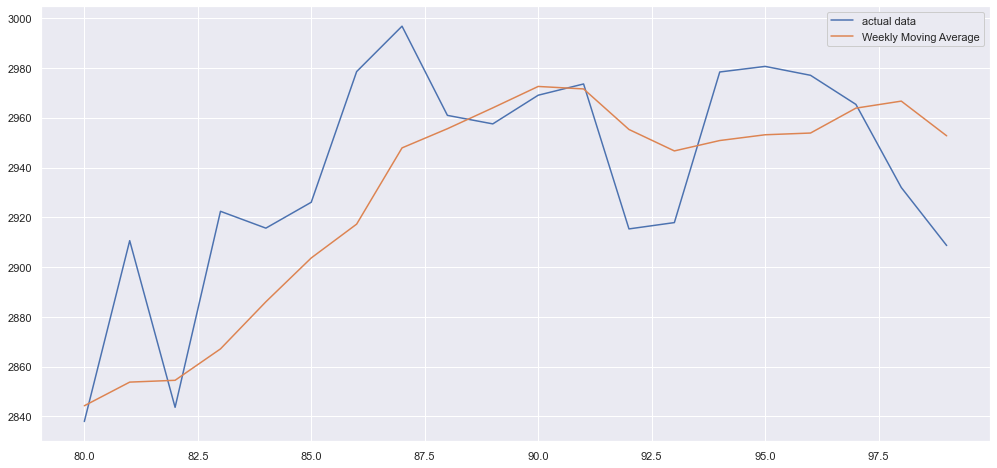

In [162]:
GOOGL['MA'] = GOOGL.iloc[:,1].rolling(window=5).mean()

plt.figure(figsize=[17,8])
plt.grid(True)
plt.plot(GOOGL['4. close'][-20:],label='actual data')
plt.plot(GOOGL['MA'][-20:],label='Weekly Moving Average')

plt.legend(framealpha=1, frameon=True);

In [163]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=5).mean()[-20:], 
    GOOGL['4. close'][-20:])

1083.7187668000013

Moving average smooths out price trends by filtering out "noise" from random short-term price fluctuations. From the above graph we can see that moving the average on a weekly basis does smoothen out the price values, but still follows the general shape of the actual prices, leading us to believe that this is a good model. The MSE of this model is also 1084

#### Smoothing Average Monthly

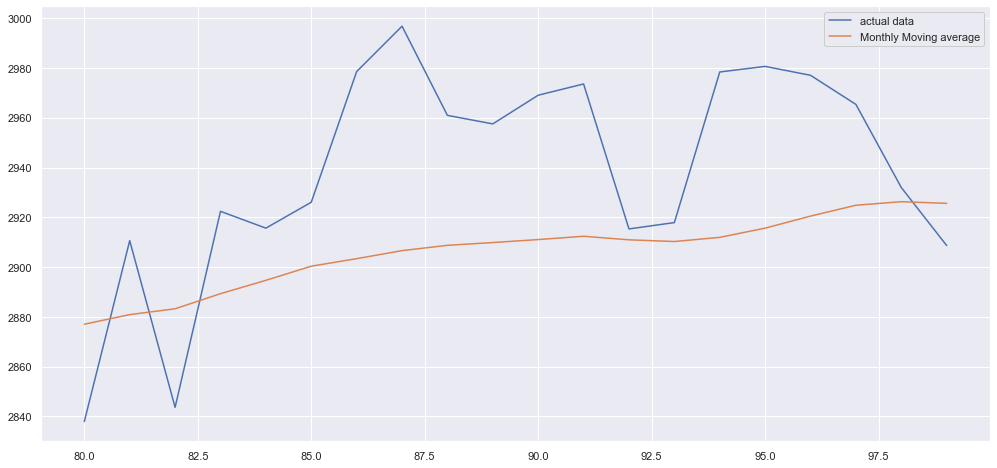

In [164]:
GOOGL['MA'] = GOOGL.iloc[:,1].rolling(window=30).mean()

plt.figure(figsize=[17,8])
plt.grid(True)
plt.plot(GOOGL['4. close'][-20:],label='actual data')
plt.plot(GOOGL['MA'][-20:],label='Monthly Moving average')

plt.legend(framealpha=1, frameon=True);

In [165]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=30).mean()[-20:], 
    GOOGL['4. close'][-20:])

2296.3740949166663

From the graph above, we can see that moving the average on a monthly basis smoothens out the actual price values too much, such that the model does not follow the shape of the actual price values. The MSE of this model is also 2296. This is a high MSE and this may be a bad model and should not be used

#### Smoothing Average by 3 months

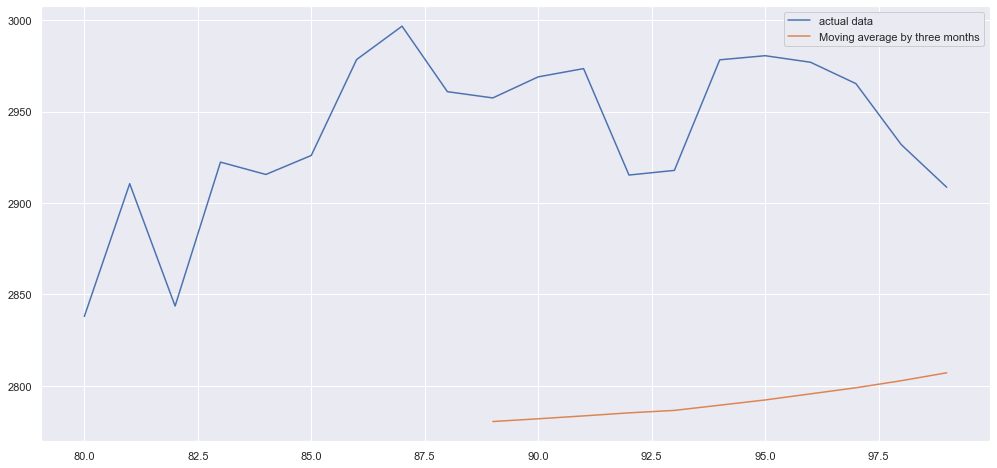

In [166]:
GOOGL['MA'] = GOOGL.iloc[:,1].rolling(window=90).mean()

plt.figure(figsize=[17,8])
plt.grid(True)
plt.plot(GOOGL['4. close'][-20:],label='actual data')
plt.plot(GOOGL['MA'][-20:],label='Moving average by three months')

plt.legend(framealpha=1, frameon=True);

In [167]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=90).mean()[-20:].notnull(), 
    GOOGL['4. close'][-20:])

8632719.042985003

From the above, we can see that moving the average by the previous quarter smoothens out the price values far too much, such that the model is very far from the actual price values. The MSE is 8632719. As such we believe this is a terrible model and should not be used

### Model 4. Exponential Smoothing

$y = \alpha x_t + (1 - \alpha)y_{t-1}, t > 0$

Like moving average, exponential smoothing also filters out the noise from short term fluctuations. However exponential smoothing assigns exponentially decreasing weights as a data point gets older, this means that an older data point has less weight to the model than the newest data point. The alpha parameters dictate how important the current data point is for the model. </p>

The alpha parameter can be between 0 and 1 inclusive. The closer alpha is to 1 the more similar the model will be to the actual prices and the lower the MSE. However, if the alpha is too close to 1 the model will be too similar to the actual prices, and hence no "noise filtering" would be done

In [181]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

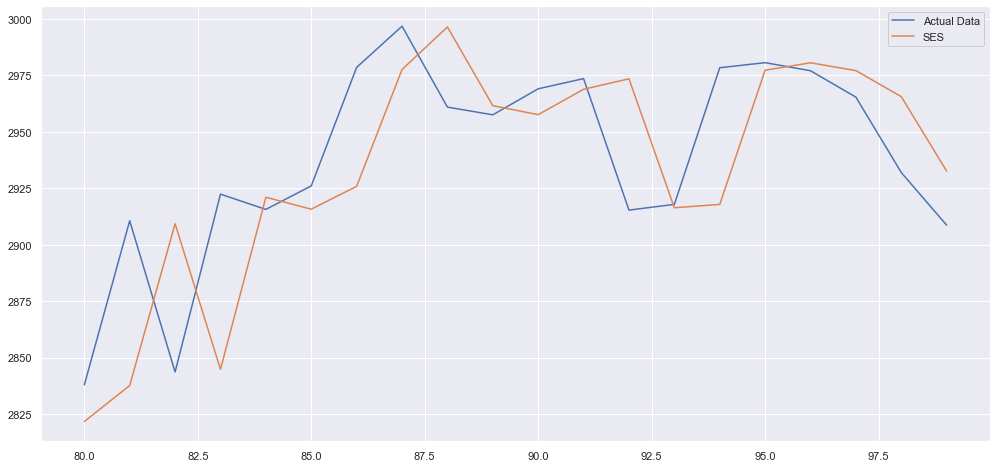

In [182]:
fit1 = SimpleExpSmoothing(GOOGL['4. close'], initialization_method="estimated").fit(optimized=True) #this model uses single exponential smoothing

# plot
plt.figure(figsize=(17, 8))


plt.plot(GOOGL['4. close'][-20:], label='Actual Data')
plt.plot(fit1.fittedvalues[-20:], label='SES')

plt.legend(framealpha=1, frameon=True);

In [183]:
print("alpha \t:", fit1.model.params["smoothing_level"])
print("MSE \t:",mean_squared_error(fit1.fittedvalues[-21:-1], GOOGL['4. close'][-21:-1]))

alpha 	: 0.9821422645953692
MSE 	: 1519.8097422427225


The computer has optimized the SES model to have an alpha of 0.9821, giving an MSE of 1520. The model also follows the shape of the original data. As such, we believe we can use this model

### Model 5. Double Exponential Smoothing

Double Exponential Smoothing is used when there is a trend in the time series. In that case, . 

$y = \alpha x_t + (1 - \alpha)(y_{t-1} + b_{t-1})$

$b_t = \beta (y_t - y_{t-1}) + (1 - \beta)b_{t-1}$

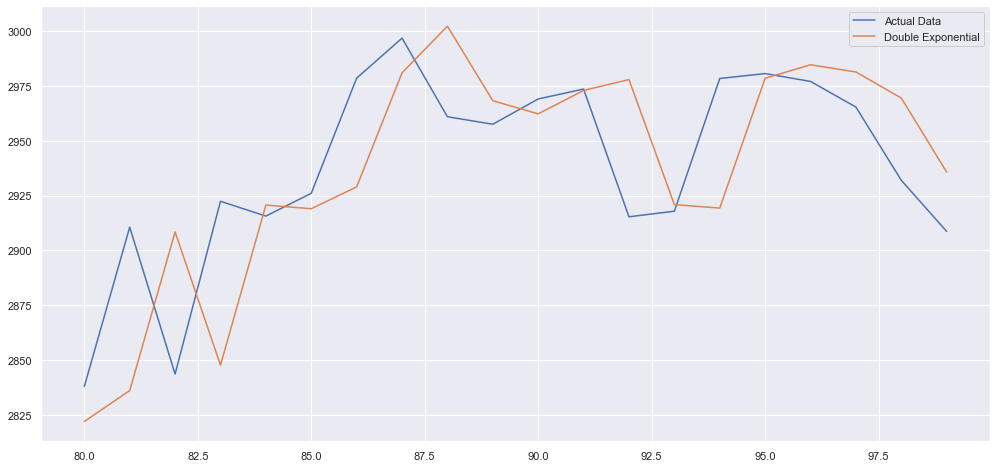

In [184]:
fit1 = Holt(GOOGL['4. close'], initialization_method="estimated").fit(optimized=True)

# plot
plt.figure(figsize=(17, 8))


plt.plot(GOOGL['4. close'][-20:], label='Actual Data')
plt.plot(fit1.fittedvalues[-20:], label='Double Exponential')

plt.legend(framealpha=1, frameon=True);

In [186]:
print("Double Exponential Model")
print("alpha \t:", fit1.model.params["smoothing_level"])
print("beta \t:", fit1.model.params["smoothing_trend"])
print("MSE \t:",mean_squared_error(fit1.fittedvalues[-21:-1], GOOGL['4. close'][-21:-1]))

Double Exponential Model
alpha 	: 0.9330305185628779
beta 	: 0.051427206855904364
MSE 	: 1538.0582173038683


For our double exponential model the alpha is 0.933, beta is 0.051, giving us an MSE of 1538. This model is very similar to the Simple Exponential model but has an additional parameter. This however leads to a slightly higher MSE but still follows the original data well and can therefore be used